# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 06.10.2021

Мягкий дедлайн: 23:59MSK 25.10.2021

Жесткий дедлайн: 23:59MSK 28.10.2021

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-10-28 15:27:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  22.4MB/s    in 9.9s    

2021-10-28 15:27:39 (20.3 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.6

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
rmse = []
for a in [0.1, 1, 10, 100, 200]:
  ridge = Ridge(alpha = a)
  ridge.fit(X_train, y_train)
  y_pred_a1 = ridge.predict(X_test)
  rmse.append(mean_squared_error(y_test, y_pred_a1, squared=False))

In [ ]:
print("RMSE for ridge regression:", "\na = 0.1, RMSE = {}".format(rmse[0]),
      "\na = 1, RMSE = {}".format(rmse[1]),
      "\na = 10, RMSE = {}".format(rmse[2]),
      "\na = 100, RMSE = {}".format(rmse[3]),
      "\na = 200, RMSE = {}".format(rmse[4]),
      "\nThe best one with a = {}".format([0.1, 1, 10, 100, 200][rmse.index(min(rmse))]))

RMSE for ridge regression: 
a = 0.1, RMSE = 9.510160707877098 
a = 1, RMSE = 9.510160711373395 
a = 10, RMSE = 9.510160746337895 
a = 100, RMSE = 9.510161096134519 
a = 200, RMSE = 9.510161485120747 
The best one with a = 0.1


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



## Предобработка данных

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

g = torch.Generator()
g.manual_seed(0)

In [ ]:
X_train.shape

(463715, 90)

In [ ]:
X_test.shape

(51630, 90)

In [ ]:
# Разделим года на декады для визуализаци
df['decade'] = df[0].apply(lambda year : year-(year%10))

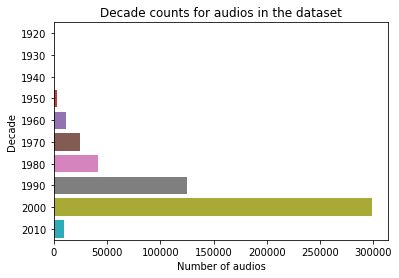

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(y='decade', data=df)
plt.xlabel("Number of audios")
plt.ylabel("Decade")
plt.title("Decade counts for audios in the dataset");

Мы видим, что большинство аудиозаписей принадлежит к годам с 2000 по 2010. Можно посмотеть подробнее, какой именно год является самым популярным:

In [ ]:
df_year = df.loc[(df[0] - df[0]%10) == 2000]

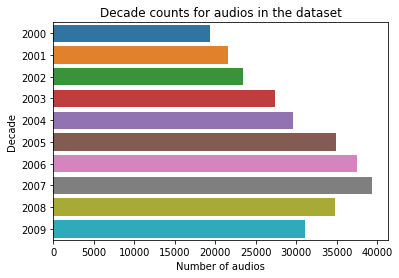

In [ ]:
sns.countplot(y=df_year[0], data=df_year)
plt.xlabel("Number of audios")
plt.ylabel("Decade")
plt.title("Decade counts for audios in the dataset");

Распределение по годам внутри декады 2000х примерно равномерное.

In [ ]:
# Видно, что распределение значений внутри параметров очень варьирует
df.iloc[:,:-1].describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,-0.146527,2.546063,33.714006,2439.359375,1967.734202,1514.859902,910.981344,879.146721,603.737434,517.579339,393.962215,325.733170,288.885085,291.973238,43.031969,43.314873,-46.449006,-27.672783,14.958491,44.514859,5.131786,24.034309,9.498816,-4.178856,0.499475,72.652267,-51.441256,117.921056,-189.880885,...,6.378511,28.294082,12.772241,1.700474,-10.205155,64.101262,104.822085,-0.026481,38.678040,-27.989985,3.301739,0.307127,-0.478828,-138.223224,-0.696065,0.242582,3.151751,27.642745,31.822244,-0.835950,-8.931564,4.849253,-27.347646,-11.938792,-21.572137,-5.576196,-23.304324,31.113053,-104.974794,26.962393,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,4.370848,8.320190,22.259632,1749.367690,1261.484792,1092.831044,475.708203,576.865994,317.499288,309.364735,214.013502,165.699383,186.960729,153.475649,121.429498,715.759147,544.879865,218.368476,163.215789,134.887832,99.088119,71.809934,74.411680,53.517036,42.490396,107.912629,415.039100,453.399231,260.645370,...,93.555672,75.049277,69.981849,83.278660,57.806591,273.827189,311.135298,266.774027,169.072163,144.083035,59.447204,49.181425,37.675424,308.187390,222.198519,128.140961,99.920949,116.696176,106.359938,36.799193,251.606754,229.060421,163.782620,63.288891,64.691545,26.358175,268.190912,144.156203,201.137522,123.847891,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,-69.680870,-94.041960,0.132830,8.474200,21.214350,17.857900,12.150420,5.517710,19.808810,6.254870,6.183760,15.307500,6.116440,5.177340,-2821.430210,-13390.360690,-12017.088870,-4324.864700,-3357.279900,-3115.374560,-3805.666170,-1516.356440,-1679.118320,-1590.637130,-989.645800,-1711.484000,-8448.194880,-10095.725950,-9803.759040,...,-2270.811070,-1746.478220,-3188.177380,-2199.782210,-1694.260320,-5154.024360,-5111.601750,-4730.599100,-3756.490790,-2499.954680,-1900.104800,-1396.701680,-600.090760,-10345.833280,-7375.977440,-3896.275220,-1199.004420,-2564.788120,-1904.984320,-974.702480,-7057.712450,-6953.357360,-8400.603300,-1812.889440,-1387.505490,-718.421050,-9831.453860,-2025.778160,-8390.035450,-4754.937170,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.

### 1) Проверяем на наличие пустых строк

In [ ]:
for column in df.columns:
  nulls = df.isna()[column].sum()
  if nulls != 0:
    print("{}, number of NA = {}".format(column, df.isna()[column].sum()))
# пустых строк нет

### 2) Поскольку в нашем датасете года распределены неравномерно, чтобы не было дисбаланса при обучении, возьмем в тренировочную выборку одинаковое число примеров аудио из разных декад.

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,decade
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327,2000
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061,2000
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345,2000
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382,2000
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903,2000


In [ ]:
# отбираем, какие строки будем использовать для обучения из всей тестовой выборки
df_train = df.iloc[:train_size, :]

# аудио, датированные раньше 1940 года, встречаются очень редко по сравнению с остальными, поэтому мы пренебрежем этими видео в нашей выборке
df_train = df_train[df_train[0] > 1940]

min_samples = df_train.decade.value_counts().min()
decades = df_train.decade.unique()
df_train_eq = pd.DataFrame(columns=df_train.columns)

for decade in decades:
    df_train_eq = df_train_eq.append(df_train[df_train.decade==decade].sample(min_samples))

df_train_eq.decade = df_train_eq.decade.astype(int)

# разделяем признаки и целевую переменную
X_train_eq = df_train_eq.iloc[:, 1:-1].values
y_train_eq = df_train_eq.iloc[:, 0].values

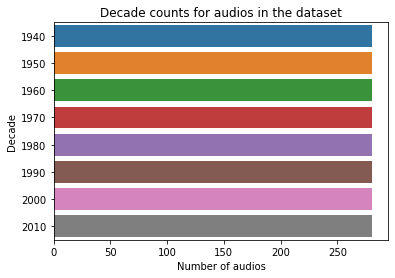

In [ ]:
sns.countplot(y='decade', data=df_train_eq)
plt.xlabel("Number of audios")
plt.ylabel("Decade")
plt.title("Decade counts for audios in the dataset"); # теперь в нашем датасете представлено одинаковое число всех десятилетий

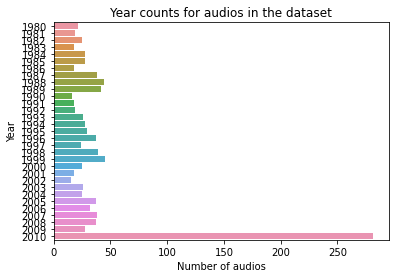

In [ ]:
data = df_train_eq[df_train_eq.decade > 1970]
sns.countplot(y=data[0], data=data)
plt.xlabel("Number of audios")
plt.ylabel("Year")
plt.title("Year counts for audios in the dataset"); # но важно отметить, что года после 2010 представлены только 2010 и 2011 в исходной выборке, и только 2010 в нашей подвыборке

Идея классная, но эксперименты показали, что это не очень эффективно. Вероятно, потому что в такой выборке в целом не очень много сэмплов - меньше 3000.

### 3) Нормализация с помощью MinMax scaler

In [ ]:
assert X_train_eq.shape[1] == 90

In [ ]:
X.dtype # в датасете только float

dtype('float64')

Для возвращения к исходным значениям:


In [ ]:
y_train_max = max(y_train)
y_train_min = min(y_train)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#X_train_eq = scaler.fit_transform(X_train_eq)
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

In [ ]:
y_train.shape

(463715,)

In [ ]:
scaler.fit(y_train.reshape(-1, 1))

#y_train_eq = scaler.transform(y_train_eq.reshape(-1, 1))
y_train_norm = scaler.transform(y_train.reshape(-1, 1))
y_test_norm = scaler.transform(y_test.reshape(-1, 1))

scale = scaler.scale_ # второй путь вернуться к исходным значениям до нормализации

In [ ]:
scaler.scale_

array([0.01123596])

In [ ]:
pd.DataFrame(X_test_norm).describe() # смотрим на нормализованные даные

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
count,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,...,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000,51630.000000
mean,0.685040,0.526995,0.499874,0.213373,0.448145,0.217868,0.562563,0.303787,0.474489,0.530103,0.413696,0.528691,0.083743,0.054844,0.094511,0.062788,0.085725,0.087990,0.048575,0.091458,0.064118,0.112436,0.066206,0.055272,0.461477,0.470622,0.512789,0.517757,0.514955,0.434951,0.374017,0.476654,0.306945,0.397188,0.513032,0.363843,0.463526,0.504779,0.545489,0.595737,...,0.546173,0.490443,0.427278,0.545882,0.671993,0.528469,0.217697,0.324868,0.448227,0.464785,0.335364,0.660157,0.522735,0.401634,0.557187,0.475232,0.485420,0.412448,0.199656,0.671837,0.685911,0.563135,0.687576,0.425961,0.462119,0.626690,0.535680,0.569944,0.462781,0.615865,0.349313,0.626083,0.408746,0.512819,0.564941,0.473637,0.578802,0.403110,0.267586,0.361368
std,0.111284,0.088689,0.069438,0.038149,0.082157,0.058151,0.073691,0.043233,0.066280,0.088596,0.029184,0.052970,0.056491,0.040059,0.062731,0.047358,0.047756,0.059085,0.027289,0.057845,0.036836,0.063963,0.047408,0.029434,0.040740,0.025226,0.029034,0.038534,0.047029,0.042595,0.026288,0.036985,0.025264,0.024616,0.032397,0.047820,0.032374,0.039339,0.024717,0.028411,...,0.038460,0.034494,0.023285,0.029748,0.038509,0.028083,0.019911,0.028064,0.020216,0.037464,0.024346,0.023560,0.033098,0.020747,0.039699,0.026077,0.041469,0.026619,0.022723,0.025744,0.034054,0.025961,0.028337,0.036981,0.039070,0.031984,0.021595,0.039844,0.020821,0.023000,0.042920,0.036460,0.044686,0.027771,0.041743,0.030455,0.035213,0.033792,0.020293,0.021214
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.620237,0.480768,0.459882,0.190562,0.397877,0.177562,0.519986,0.278099,0.436642,0.471208,0.396941,0.496427,0.044510,0.028917,0.051313,0.031871,0.054774,0.047684,0.030585,0.053809,0.040340,0.069431,0.035757,0.036976,0.442745,0.458904,0.501774,0.501495,0.492965,0.413320,0.362183,0.460961,0.295437,0.385933,0.499887,0.338045,0.449649,0.485479,0.535870,0.582816,...,0.527657,0.472990,0.416765,0.532771,0.659485,0.514809,0.208519,0.311843,0.438588,0.447168,0.323652,0.649671,0.506655,0.393223,0.541310,0.464398,0.464657,0.401870,

In [ ]:
pd.DataFrame(y_train_eq).describe()

,0
count,2248.000000
mean,0.649796
std,0.244465
min,0.213483
25%,0.424157
50%,0.646067
75%,0.867978
max,0.988764


In [ ]:
pd.DataFrame(y_test_norm).describe()

,0
count,51630.000000
mean,0.859503
std,0.121933
min,0.056180
25%,0.820225
50%,0.898876
75%,0.943820
max,0.988764


### 4) Можно попробовать применить метод главных компенент:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(.90)

# обучаем только на тренировочной выборке
pca.fit(X_train_norm)

# число компонент на выходе
n_input = pca.n_components_
n_input

39

In [ ]:
X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

In [ ]:
X_train_pca.shape

(463715, 39)

In [ ]:
X_test_pca.shape

(51630, 39)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# переводим в numpy arrays в тензоры
tensor_X_train_pca = torch.from_numpy(X_train_pca)
tensor_X_test_pca = torch.from_numpy(X_test_pca)

tensor_X_train = torch.from_numpy(X_train_norm)
tensor_y_train = torch.from_numpy(y_train_norm).view(-1,1) 

tensor_X_test = torch.from_numpy(X_test_norm) 
tensor_y_test = torch.from_numpy(y_test_norm).view(-1,1)

bs = 200

# создаем datasets и loaders
train_set = TensorDataset(tensor_X_train, tensor_y_train) 
train_loader = DataLoader(train_set, batch_size = bs, shuffle=True, worker_init_fn=set_random_seed,
    generator=g) 

test_set = TensorDataset(tensor_X_test, tensor_y_test) 
test_loader = DataLoader(test_set, batch_size = bs, shuffle=True, worker_init_fn=set_random_seed,
    generator=g)  

# для проверки pca
train_set_pca = TensorDataset(tensor_X_train_pca, tensor_y_train) 
train_loader_pca = DataLoader(train_set_pca, batch_size = bs, shuffle=True, worker_init_fn=set_random_seed,
    generator=g) 

test_set_pca = TensorDataset(tensor_X_test_pca, tensor_y_test) 
test_loader_pca = DataLoader(test_set_pca, batch_size = bs, shuffle=True, worker_init_fn=set_random_seed,
    generator=g) 

In [ ]:
# пишем RMSE loss, source: https://discuss.pytorch.org/t/rmse-loss-function/16540/3
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [ ]:
from collections import namedtuple

LossInfo = namedtuple(
    "LossInfo", 
    ["train_epoch_losses", "eval_epoch_losses"]
)

## Тренировочная функция

In [ ]:
def train_model(model, optimizer, criterion, train_loader, validloader, n_epochs) -> torch.Tensor:
        '''
        params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        n_epochs - number of epochs
        '''
        epoch_train_losses = []
        epoch_eval_losses = []
        min_valid_loss = np.inf
        #loss_tensor = torch.zeros(size=(n_epochs,), dtype=torch.float64)

        for e in range(n_epochs):
            model.train()     # Optional when not using Model Specific layer
            train_loss = 0.0

            for data, labels in train_loader:
                if torch.cuda.is_available():
                    data, labels = data.cuda(), labels.cuda()
                
                optimizer.zero_grad()
                target = model(data.float())
                loss = criterion(target.float(),labels.float())
                loss.backward()
                optimizer.step()

                train_loss += loss.item()            
            
            epoch_train_losses.append(train_loss / (len(train_loader) * scale))

            valid_loss = 0.0
            valid_loss_wo_norm = 0
            loss_wo_norm = 0.0

            model.eval()     # Optional when not using Model Specific layer
            with torch.no_grad():
              for data, labels in validloader:
                  if torch.cuda.is_available():
                      data, labels = data.cuda(), labels.cuda()
                  
                  target = model(data.float())
                  target_unnorm = target * (y_train_max - y_train_min) + y_train_min
                  labels_unnorm = labels * (y_train_max - y_train_min) + y_train_min
                  loss = criterion(target_unnorm.float(),labels_unnorm.float())
                  valid_loss += loss.item()

            epoch_eval_losses.append(valid_loss / len(validloader))

            if e < 16 or e == n_epochs:
              print(f'Epoch {e+1} \t\t Training Loss: {train_loss / (len(train_loader) * scale)} \t\t Validation Loss: {valid_loss / len(validloader)}')

            if min_valid_loss > valid_loss:
              print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
              min_valid_loss = valid_loss
              # Saving State Dict
              torch.save(model.state_dict(), 'saved_model.pth')
        return LossInfo(epoch_train_losses, epoch_eval_losses)
        

In [ ]:
criterion = RMSELoss()
#LR = 0.0001
#n_epochs = 15

## Подбор параметров

### 1) Подбор Learning rate

Базовая модель с 3 слоями и нелинейностью Relu после каждого полносвязного слоя, будем обучать 15 эпох каждую.
Как можно видеть, базовая модель очень плоха -- на ней лосс больше, чем у линейной регрессии, обученной выше.

In [ ]:
scale

array([0.01123596])

Epoch 1 		 Training Loss: [10.27635045] 		 Validation Loss: 11.390758812657655
Validation Loss Decreased(inf--->2950.206532) 	 Saving The Model
Epoch 2 		 Training Loss: [9.58862367] 		 Validation Loss: 11.263589163084287
Validation Loss Decreased(2950.206532--->2917.269593) 	 Saving The Model
Epoch 3 		 Training Loss: [9.50762718] 		 Validation Loss: 11.672980245936332
Epoch 4 		 Training Loss: [9.42249108] 		 Validation Loss: 9.974229505163363
Validation Loss Decreased(2917.269593--->2583.325442) 	 Saving The Model
Epoch 5 		 Training Loss: [9.39980903] 		 Validation Loss: 9.992766304826183
Epoch 6 		 Training Loss: [9.32945412] 		 Validation Loss: 11.342593345863019
Epoch 7 		 Training Loss: [9.25200047] 		 Validation Loss: 12.684180454858021
Epoch 8 		 Training Loss: [9.22705139] 		 Validation Loss: 11.14638140394881
Epoch 9 		 Training Loss: [9.21494144] 		 Validation Loss: 11.068063875883242
Epoch 10 		 Training Loss: [9.18867679] 		 Validation Loss: 10.594141093000022
Epoch 11 	

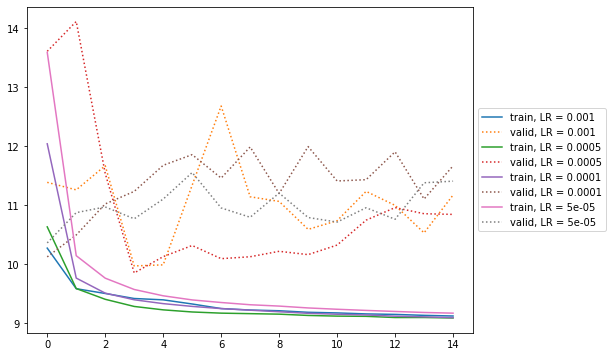

In [ ]:
# создаем нейросеть
n_input = 90
def get_model(n_input):
    set_random_seed(13) # используем функцию для фиксации рендом сида
    return torch.nn.Sequential(
    nn.Linear(n_input, 100), 
    nn.ReLU(),
    nn.Linear(100, 45),
    nn.ReLU(),
    nn.Linear(45, 1),
    nn.ReLU()     
)
    
fig = plt.figure()
fig.set_size_inches(8, 6)
ax = plt.subplot(111)

for LR in [0.001, 0.0005, 0.0001, 0.00005]:
  model_three_l = get_model(n_input)
  optimizer = torch.optim.Adam(model_three_l.parameters(), lr=LR)
  three_l = train_model(model_three_l, optimizer, criterion, train_loader, test_loader, n_epochs)
  print("Loss on the 15 epoch: training {}, validation {}".format(three_l[0][14], three_l[1][14]))
  print("Next try!")

  ax.plot(
    np.arange(n_epochs),
    three_l[0],
    label="train, LR = {}".format(LR)
  )
  ax.plot(
      np.arange(n_epochs),
      three_l[1],
      label="valid, LR = {}".format(LR), linestyle = ':'
  )

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Понятно, что на масштабе в 15 эпох трудно сделать вывод о наилучшем значении, однако мы можем видеть, что качество на валидационной выборке падает при LR = 0.0005. Также видно (из выводы программы выше), что минимальный лосс на тесте достигается при LR = 0.0005 и 0.0001.

### 0) Проверка, будет ли модель работать лучше на PCA

In [ ]:
# создаем нейросеть
n_input = pca.n_components_
def get_model(n_input):
    set_random_seed(13) # используем функцию для фиксации рендом сида
    return torch.nn.Sequential(
    nn.Linear(n_input, 100),
    nn.ReLU(),
    nn.Linear(100, 45),
    nn.ReLU(),
    nn.Linear(45, 1),
    nn.ReLU()     
)

model_pca = get_model(n_input)
optimizer = torch.optim.Adam(model_pca.parameters(), lr=0.0005)
pca = train_model(model_pca, optimizer, criterion, train_loader_pca, test_loader_pca, n_epochs)

Epoch 1 		 Training Loss: [10.71339468] 		 Validation Loss: 10.592704399211987
Validation Loss Decreased(inf--->2743.510439) 	 Saving The Model
Epoch 2 		 Training Loss: [8.99361236] 		 Validation Loss: 10.14824322107676
Validation Loss Decreased(2743.510439--->2628.394994) 	 Saving The Model
Epoch 3 		 Training Loss: [8.94221508] 		 Validation Loss: 10.309964481928173
Epoch 4 		 Training Loss: [8.90381357] 		 Validation Loss: 10.173383530502614
Epoch 5 		 Training Loss: [8.86985837] 		 Validation Loss: 10.03417850185085
Validation Loss Decreased(2628.394994--->2598.852232) 	 Saving The Model
Epoch 6 		 Training Loss: [8.84747383] 		 Validation Loss: 10.254501121845024
Epoch 7 		 Training Loss: [8.82941279] 		 Validation Loss: 10.139045667464208
Epoch 8 		 Training Loss: [8.81366325] 		 Validation Loss: 10.294244865653138
Epoch 9 		 Training Loss: [8.79667503] 		 Validation Loss: 10.825148192151634
Epoch 10 		 Training Loss: [8.78690535] 		 Validation Loss: 11.013725428047328
Epoch 11 

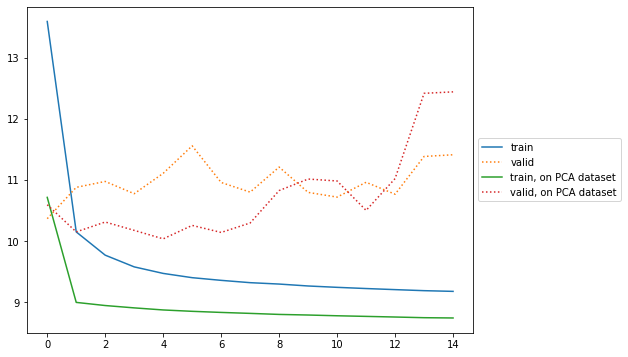

In [ ]:
fig = plt.figure()
fig.set_size_inches(8, 6)
ax = plt.subplot(111)

ax.plot(
    np.arange(n_epochs),
    three_l[0],
    label="train"
  )
ax.plot(
      np.arange(n_epochs),
      three_l[1],
      label="valid", linestyle = ':'
  )

ax.plot(
      np.arange(n_epochs),
      pca[0],
      label="train, on PCA dataset"
  )
ax.plot(
      np.arange(n_epochs),
      pca[1],
      label="valid, on PCA dataset", linestyle = ':'
  )

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Видно, что качство на валидационной выборке у обоих моделей отвратительное, но зато на PCA сильно лучше получается подстраиваться под треин. Поэтому дальнейшем будем использовать PCA датасет.

### 2) Добавление BatchNorm

BatchNorm нормализует батчи, которые использует слой. Это важно, поскольку даже после номализаци исходных данных, в батчи могут попадать данные с параметрами из разных концов распределения. Предполагается, что после нормализации батча качество нейросети будет выше, чем на ненормализованном.

In [ ]:
# создаем нейросеть
def get_model(n_input):
    set_random_seed(13) # используем функцию для фиксации рендом сида
    return torch.nn.Sequential(
    nn.Linear(n_input, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 45),
    nn.ReLU(),
    nn.Linear(45, 1),
    nn.ReLU()     
)

model_three_bn100 = get_model(n_input)
optimizer = torch.optim.Adam(model_three_bn100.parameters(), lr=0.0005)
three_bn100 = train_model(model_three_bn100, optimizer, criterion, train_loader_pca, test_loader_pca, n_epochs)

Epoch 1 		 Training Loss: [10.76571316] 		 Validation Loss: 13.506724545394132
Validation Loss Decreased(inf--->3498.241657) 	 Saving The Model
Epoch 2 		 Training Loss: [9.07754546] 		 Validation Loss: 10.336499733354135
Validation Loss Decreased(3498.241657--->2677.153431) 	 Saving The Model
Epoch 3 		 Training Loss: [8.96795294] 		 Validation Loss: 10.775039006384183
Epoch 4 		 Training Loss: [8.91031179] 		 Validation Loss: 11.66014355766267
Epoch 5 		 Training Loss: [8.86075789] 		 Validation Loss: 11.919894973283569
Epoch 6 		 Training Loss: [8.82736032] 		 Validation Loss: 14.128716984310666
Epoch 7 		 Training Loss: [8.79877578] 		 Validation Loss: 12.684014861648148
Epoch 8 		 Training Loss: [8.77954004] 		 Validation Loss: 12.262268556130898
Epoch 9 		 Training Loss: [8.75927725] 		 Validation Loss: 12.013208912146137
Epoch 10 		 Training Loss: [8.7397124] 		 Validation Loss: 10.267043084251375
Validation Loss Decreased(2677.153431--->2659.164159) 	 Saving The Model
Epoch 11 

In [ ]:

def get_model(n_input):
    set_random_seed(13) # используем функцию для фиксации рендом сида
    return torch.nn.Sequential(
    nn.Linear(n_input, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 45),
    nn.BatchNorm1d(45),
    nn.ReLU(),
    nn.Linear(45, 1),
    nn.ReLU()     
)

model_three_bn100_45 = get_model(n_input)
optimizer = torch.optim.Adam(model_three_bn100_45.parameters(), lr=0.0005)
three_bni100_45 = train_model(model_three_bn100_45, optimizer, criterion, train_loader_pca, test_loader_pca, n_epochs)

Epoch 1 		 Training Loss: [11.24290476] 		 Validation Loss: 12.906548621571662
Validation Loss Decreased(inf--->3342.796093) 	 Saving The Model
Epoch 2 		 Training Loss: [9.18944998] 		 Validation Loss: 11.656912251328869
Validation Loss Decreased(3342.796093--->3019.140273) 	 Saving The Model
Epoch 3 		 Training Loss: [9.03705303] 		 Validation Loss: 10.999544953747606
Validation Loss Decreased(3019.140273--->2848.882143) 	 Saving The Model
Epoch 4 		 Training Loss: [8.96939756] 		 Validation Loss: 11.748698396572275
Epoch 5 		 Training Loss: [8.91413055] 		 Validation Loss: 11.332370507671106
Epoch 6 		 Training Loss: [8.8824501] 		 Validation Loss: 11.21722209959877
Epoch 7 		 Training Loss: [8.85306996] 		 Validation Loss: 12.017884884101544
Epoch 8 		 Training Loss: [8.82160009] 		 Validation Loss: 11.503642524071182
Epoch 9 		 Training Loss: [8.80408475] 		 Validation Loss: 11.559641035367163
Epoch 10 		 Training Loss: [8.78415999] 		 Validation Loss: 11.951545899439042
Epoch 11 

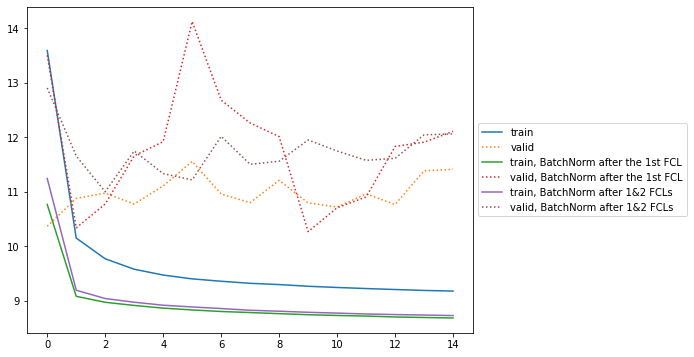

In [ ]:
fig = plt.figure()
fig.set_size_inches(8, 6)
ax = plt.subplot(111)

ax.plot(
    np.arange(n_epochs),
    three_l[0],
    label="train"
  )
ax.plot(
      np.arange(n_epochs),
      three_l[1],
      label="valid", linestyle = ':'
  )
ax.plot(
      np.arange(n_epochs),
      three_bn100[0],
      label="train, BatchNorm after the 1st FCL"
  )
ax.plot(
      np.arange(n_epochs),
      three_bn100[1],
      label="valid, BatchNorm after the 1st FCL", linestyle = ':'
  )

ax.plot(
      np.arange(n_epochs),
      three_bni100_45[0],
      label="train, BatchNorm after 1&2 FCLs"
  )
ax.plot(
      np.arange(n_epochs),
      three_bni100_45[1],
      label="valid, BatchNorm after 1&2 FCLs", linestyle = ':'
  )

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Как мы видим -- это достаточно полезная модификация модели, но только если смотреть на тренировочную выборку, с валидационной выборкой все даже хуже, чем у нейросети без BatchNorm...

### 3) Добавление Dropout слоя

Дропаут борется с переобучением - слишком сильным подстраиванием под тренировочную выборку. Этот метод выкидывает некоторое количество нейронов из (полносвязного) слоя, таким образом, "валидируя" веса в экстремальных условиях.
\
У дропаута есть параметр - вероятность выкидывания нейрона. Я встречала от 0.2 до 0.6, проверим тут, что больше подходит нашей модели.

Epoch 1 		 Training Loss: [13.11763198] 		 Validation Loss: 17.6190175200061
Validation Loss Decreased(inf--->4563.325538) 	 Saving The Model
Epoch 2 		 Training Loss: [9.26525939] 		 Validation Loss: 14.54353327364535
Validation Loss Decreased(4563.325538--->3766.775118) 	 Saving The Model
Epoch 3 		 Training Loss: [9.10364321] 		 Validation Loss: 13.524782261793218
Validation Loss Decreased(3766.775118--->3502.918606) 	 Saving The Model
Epoch 4 		 Training Loss: [9.06273639] 		 Validation Loss: 14.729985248168003
Epoch 5 		 Training Loss: [9.0349695] 		 Validation Loss: 12.831030083439066
Validation Loss Decreased(3502.918606--->3323.236792) 	 Saving The Model
Epoch 6 		 Training Loss: [9.00573686] 		 Validation Loss: 12.132066914473722
Validation Loss Decreased(3323.236792--->3142.205331) 	 Saving The Model
Epoch 7 		 Training Loss: [8.99057592] 		 Validation Loss: 13.134797722216279
Epoch 8 		 Training Loss: [8.97772154] 		 Validation Loss: 15.039317786463439
Epoch 9 		 Training Lo

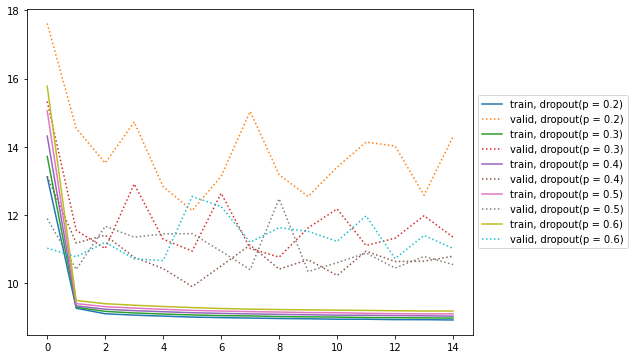

In [ ]:
fig = plt.figure()
fig.set_size_inches(8, 6)
ax = plt.subplot(111)


for p in [0.2, 0.3, 0.4, 0.5, 0.6]:

  def get_model(n_input):
      set_random_seed(13) # используем функцию для фиксации рендом сида
      return torch.nn.Sequential(
      nn.Linear(n_input, 100),
      nn.BatchNorm1d(100),
      nn.ReLU(),
      nn.Linear(100, 45),
      nn.ReLU(),
      nn.Dropout(p),
      nn.Linear(45, 1),
      nn.ReLU()     
  )

  model_do1 = get_model(n_input)
  optimizer = torch.optim.Adam(model_do1.parameters(), lr=0.0005)
  do1 = train_model(model_do1, optimizer, criterion, train_loader_pca, test_loader_pca, n_epochs)

  ax.plot(
      np.arange(n_epochs),
      do1[0],
      label="train, dropout(p = {})".format(p)
    )
  ax.plot(
        np.arange(n_epochs),
        do1[1],
        label="valid, dropout(p = {})".format(p), linestyle = ':'
    )


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Мы можем видеть, что наилучший результат достигается при p = 0.5. Теперь посмотрим, будет ли наша сеть работать лучше при добавлении второго дропаута после второго слоя.

In [ ]:
def get_model(n_input):
    set_random_seed(13) # используем функцию для фиксации рендом сида
    return torch.nn.Sequential(
    nn.Linear(n_input, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(100, 45),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(45, 1),
    nn.ReLU()     
)

model_do2 = get_model(n_input)
optimizer = torch.optim.Adam(model_do2.parameters(), lr=0.0005)
do2 = train_model(model_do2, optimizer, criterion, train_loader_pca, test_loader_pca, n_epochs)

Epoch 1 		 Training Loss: [15.74009529] 		 Validation Loss: 10.433948321692272
Validation Loss Decreased(inf--->2702.392615) 	 Saving The Model
Epoch 2 		 Training Loss: [9.56964952] 		 Validation Loss: 9.486861348612429
Validation Loss Decreased(2702.392615--->2457.097089) 	 Saving The Model
Epoch 3 		 Training Loss: [9.45830503] 		 Validation Loss: 9.650164007680296
Epoch 4 		 Training Loss: [9.41056302] 		 Validation Loss: 9.553634660124319
Epoch 5 		 Training Loss: [9.37652883] 		 Validation Loss: 9.724271800066974
Epoch 6 		 Training Loss: [9.36304636] 		 Validation Loss: 10.055614869106691
Epoch 7 		 Training Loss: [9.34180421] 		 Validation Loss: 10.690678863451748
Epoch 8 		 Training Loss: [9.33206073] 		 Validation Loss: 10.658595696379319
Epoch 9 		 Training Loss: [9.32533877] 		 Validation Loss: 10.498830942573695
Epoch 10 		 Training Loss: [9.31903737] 		 Validation Loss: 10.73983655657087
Epoch 11 		 Training Loss: [9.31663844] 		 Validation Loss: 10.996074775931458
Epoch 

In [ ]:
def get_model(n_input):
    set_random_seed(13) # используем функцию для фиксации рендом сида
    return torch.nn.Sequential(
    nn.Linear(n_input, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 45),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(45, 1),
    nn.ReLU()     
)

model_do1 = get_model(n_input)
optimizer = torch.optim.Adam(model_do1.parameters(), lr=0.0005)
do1 = train_model(model_do1, optimizer, criterion, train_loader_pca, test_loader_pca, n_epochs)

Epoch 1 		 Training Loss: [15.06126397] 		 Validation Loss: 12.240856189064997
Validation Loss Decreased(inf--->3170.381753) 	 Saving The Model
Epoch 2 		 Training Loss: [9.3984338] 		 Validation Loss: 11.523416176725998
Validation Loss Decreased(3170.381753--->2984.564790) 	 Saving The Model
Epoch 3 		 Training Loss: [9.31556552] 		 Validation Loss: 11.356852638215171
Validation Loss Decreased(2984.564790--->2941.424833) 	 Saving The Model
Epoch 4 		 Training Loss: [9.27034328] 		 Validation Loss: 10.462606137323563
Validation Loss Decreased(2941.424833--->2709.814990) 	 Saving The Model
Epoch 5 		 Training Loss: [9.2374454] 		 Validation Loss: 10.207981927054268
Validation Loss Decreased(2709.814990--->2643.867319) 	 Saving The Model
Epoch 6 		 Training Loss: [9.21237307] 		 Validation Loss: 12.054826869007243
Epoch 7 		 Training Loss: [9.18941327] 		 Validation Loss: 10.613152675186805
Epoch 8 		 Training Loss: [9.17492001] 		 Validation Loss: 10.444232498817001
Epoch 9 		 Training 

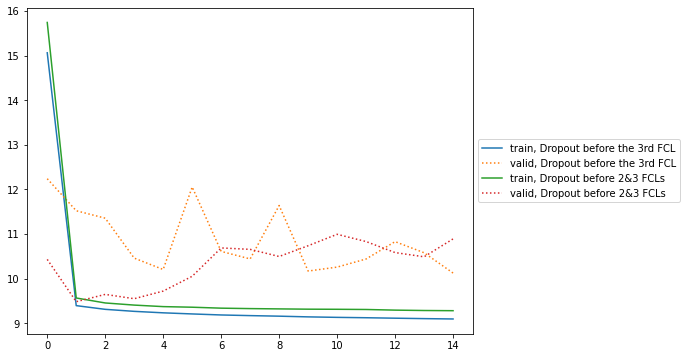

In [ ]:
fig = plt.figure()
fig.set_size_inches(8, 6)
ax = plt.subplot(111)

ax.plot(
      np.arange(n_epochs),
      do1[0],
      label="train, Dropout before the 3rd FCL"
  )
ax.plot(
      np.arange(n_epochs),
      do1[1],
      label="valid, Dropout before the 3rd FCL", linestyle = ':'
  )

ax.plot(
      np.arange(n_epochs),
      do2[0],
      label="train, Dropout before 2&3 FCLs"
  )
ax.plot(
      np.arange(n_epochs),
      do2[1],
      label="valid, Dropout before 2&3 FCLs", linestyle = ':'
  )

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Добавление второго дропаута немного улучшает качество на треине, но качество на валидационной выборке с ним хуже. Поэтому не будем использовать два дропаута дальше.

### 4) Подбор размера батча

На качество обучения также может влиять размер батча, поэтому здесь я проверяю несколько вариантов.

Epoch 1 		 Training Loss: [11.47350052] 		 Validation Loss: 12.962848577062141
Validation Loss Decreased(inf--->10461.018802) 	 Saving The Model
Epoch 2 		 Training Loss: [9.29156527] 		 Validation Loss: 11.043407295420858
Validation Loss Decreased(10461.018802--->8912.029687) 	 Saving The Model
Epoch 3 		 Training Loss: [9.23556157] 		 Validation Loss: 10.669076354087064
Validation Loss Decreased(8912.029687--->8609.944618) 	 Saving The Model
Epoch 4 		 Training Loss: [9.19822078] 		 Validation Loss: 10.055375237447178
Validation Loss Decreased(8609.944618--->8114.687817) 	 Saving The Model
Epoch 5 		 Training Loss: [9.16544497] 		 Validation Loss: 10.459555243027697
Epoch 6 		 Training Loss: [9.1400035] 		 Validation Loss: 11.646464994848882
Epoch 7 		 Training Loss: [9.12024676] 		 Validation Loss: 10.812148683280897
Epoch 8 		 Training Loss: [9.10151908] 		 Validation Loss: 10.568968566081486
Epoch 9 		 Training Loss: [9.09634075] 		 Validation Loss: 10.59212539216695
Epoch 10 		 T

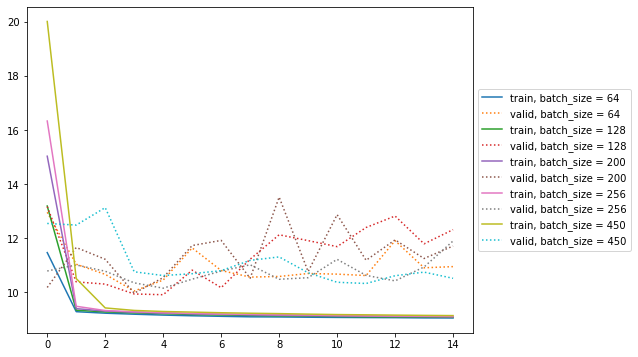

In [ ]:
fig = plt.figure()
fig.set_size_inches(8, 6)
ax = plt.subplot(111)

for bs in [64, 128, 200, 256, 450]:
  # создаем loaders
  train_loader_pca_b = DataLoader(train_set_pca, batch_size = bs, shuffle=True, worker_init_fn=set_random_seed,
      generator=g) 
  test_loader_pca_b = DataLoader(test_set_pca, batch_size = bs, shuffle=True, worker_init_fn=set_random_seed,
      generator=g)
  
  def get_model(n_input):
      set_random_seed(13) # используем функцию для фиксации рендом сида
      return torch.nn.Sequential(
      nn.Linear(n_input, 100),
      nn.BatchNorm1d(100),
      nn.ReLU(),
      nn.Linear(100, 45),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(45, 1),
      nn.ReLU()     
  )

  model_bs = get_model(n_input)
  optimizer = torch.optim.Adam(model_bs.parameters(), lr=0.0005)
  batch = train_model(model_bs, optimizer, criterion, train_loader_pca_b, test_loader_pca_b, n_epochs)

  ax.plot(
      np.arange(n_epochs),
      batch[0],
      label="train, batch_size = {}".format(bs)
    )
  ax.plot(
        np.arange(n_epochs),
        batch[1],
        label="valid, batch_size = {}".format(bs), linestyle = ':'
    )

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Лучшим оказался бэтч размером 450. Может, больше - лучше?

Epoch 1 		 Training Loss: [20.71451557] 		 Validation Loss: 13.029172842319195
Validation Loss Decreased(inf--->1355.033976) 	 Saving The Model
Epoch 2 		 Training Loss: [10.89759567] 		 Validation Loss: 12.43224091713245
Validation Loss Decreased(1355.033976--->1292.953055) 	 Saving The Model
Epoch 3 		 Training Loss: [9.49636858] 		 Validation Loss: 13.677960441662716
Epoch 4 		 Training Loss: [9.35237152] 		 Validation Loss: 13.97266597014207
Epoch 5 		 Training Loss: [9.31013711] 		 Validation Loss: 12.552351841559776
Epoch 6 		 Training Loss: [9.27817566] 		 Validation Loss: 11.244827151298523
Validation Loss Decreased(1292.953055--->1169.462024) 	 Saving The Model
Epoch 7 		 Training Loss: [9.255655] 		 Validation Loss: 10.771453325565044
Validation Loss Decreased(1169.462024--->1120.231146) 	 Saving The Model
Epoch 8 		 Training Loss: [9.23999994] 		 Validation Loss: 11.201878841106709
Epoch 9 		 Training Loss: [9.21886881] 		 Validation Loss: 10.655852015201862
Validation Loss 

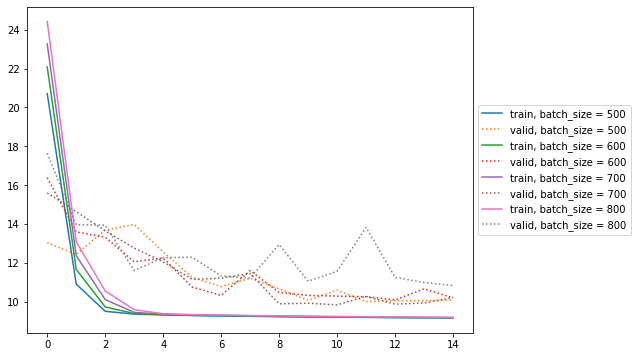

In [ ]:
fig = plt.figure()
fig.set_size_inches(8, 6)
ax = plt.subplot(111) 

for bs in [500, 600, 700, 800]:
  # создаем loaders
  train_loader_pca_b = DataLoader(train_set_pca, batch_size = bs, shuffle=True, worker_init_fn=set_random_seed,
      generator=g) 
  test_loader_pca_b = DataLoader(test_set_pca, batch_size = bs, shuffle=True, worker_init_fn=set_random_seed,
      generator=g)
  
  def get_model(n_input):
      set_random_seed(13) # используем функцию для фиксации рендом сида
      return torch.nn.Sequential(
      nn.Linear(n_input, 100),
      nn.BatchNorm1d(100),
      nn.ReLU(),
      nn.Linear(100, 45),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(45, 1),
      nn.ReLU()     
  )

  model_bs = get_model(n_input)
  optimizer = torch.optim.Adam(model_bs.parameters(), lr=0.0005)
  batch = train_model(model_bs, optimizer, criterion, train_loader_pca_b, test_loader_pca_b, n_epochs)

  ax.plot(
      np.arange(n_epochs),
      batch[0],
      label="train, batch_size = {}".format(bs)
    )
  ax.plot(
        np.arange(n_epochs),
        batch[1],
        label="valid, batch_size = {}".format(bs), linestyle = ':'
    )

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Лучше всего получается с бэтчем в 700 сэмплов, но в целом, все кроме 800 неплохи.

Далее я делаю модель с 4 слоямии, которая работает лучше. Здесь представлен подбор бетча под эту модель:

In [ ]:
# model with 4 layers with smaller batch

bs = 128
n_epochs = 15

train_loader_pca = DataLoader(train_set_pca, batch_size = bs, shuffle=True, worker_init_fn=set_random_seed,
      generator=g) 
test_loader_pca = DataLoader(test_set_pca, batch_size = bs, shuffle=True, worker_init_fn=set_random_seed,
      generator=g)

def get_model(n_input):
    set_random_seed(13) # используем функцию для фиксации рендом сида
    return torch.nn.Sequential(
    nn.Linear(n_input, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25, 1),
    nn.ReLU()     
)

model_4l_128 = get_model(n_input)
optimizer=torch.optim.SGD(model_4l_128.parameters(), momentum=0.9, lr=0.0005)
four_layers128 = train_model(model_4l_128, optimizer, criterion, train_loader_pca, test_loader_pca, n_epochs)

In [ ]:
bs = 64
n_epochs = 15

train_loader_pca = DataLoader(train_set_pca, batch_size = bs, shuffle=True, worker_init_fn=set_random_seed,
      generator=g) 
test_loader_pca = DataLoader(test_set_pca, batch_size = bs, shuffle=True, worker_init_fn=set_random_seed,
      generator=g)

def get_model(n_input):
    set_random_seed(13) # используем функцию для фиксации рендом сида
    return torch.nn.Sequential(
    nn.Linear(n_input, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25, 1),
    nn.ReLU()     
)

model_4l_64 = get_model(n_input)
optimizer=torch.optim.SGD(model_4l_64.parameters(), momentum=0.9, lr=0.0005)
four_layers64 = train_model(model_4l_64, optimizer, criterion, train_loader_pca, test_loader_pca, n_epochs)

Epoch 1 		 Training Loss: [11.27424853] 		 Validation Loss: 10.102724906089433
Validation Loss Decreased(inf--->8152.898999) 	 Saving The Model
Epoch 2 		 Training Loss: [10.15406175] 		 Validation Loss: 10.014533188854156
Validation Loss Decreased(8152.898999--->8081.728283) 	 Saving The Model
Epoch 3 		 Training Loss: [9.93297431] 		 Validation Loss: 10.106370322027761
Epoch 4 		 Training Loss: [9.80400616] 		 Validation Loss: 10.204757979368189
Epoch 5 		 Training Loss: [9.71311523] 		 Validation Loss: 10.234785065184148
Epoch 6 		 Training Loss: [9.65315535] 		 Validation Loss: 10.283082774728351
Epoch 7 		 Training Loss: [9.59723787] 		 Validation Loss: 10.45228261073135
Epoch 8 		 Training Loss: [9.55406645] 		 Validation Loss: 10.587557689260224
Epoch 9 		 Training Loss: [9.51203745] 		 Validation Loss: 10.50003084256008
Epoch 10 		 Training Loss: [9.49462994] 		 Validation Loss: 10.549744034640703
Epoch 11 		 Training Loss: [9.4659303] 		 Validation Loss: 10.509036310543358
Epo

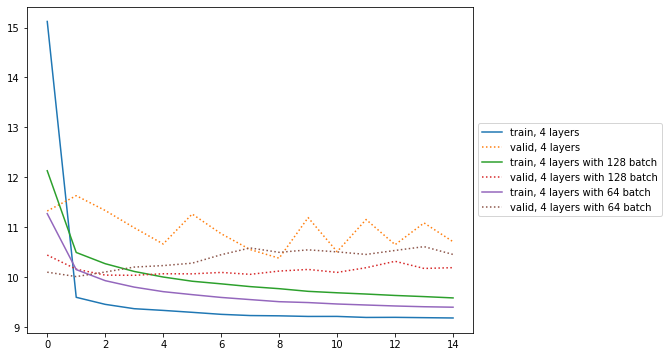

In [ ]:
fig = plt.figure()
fig.set_size_inches(8, 6)
ax = plt.subplot(111)

ax.plot(
      np.arange(n_epochs),
      four_layers[0],
      label="train, 4 layers "
  )

ax.plot(
      np.arange(n_epochs),
      four_layers[1],
      label="valid, 4 layers ", linestyle = ':'
  )

ax.plot(
      np.arange(n_epochs),
      four_layers128[0],
      label="train, 4 layers with 128 batch"
  )
ax.plot(
      np.arange(n_epochs),
      four_layers128[1],
      label="valid, 4 layers with 128 batch", linestyle = ':'
  )

ax.plot(
      np.arange(n_epochs),
      four_layers64[0],
      label="train, 4 layers with 64 batch"
  )
ax.plot(
      np.arange(n_epochs),
      four_layers64[1],
      label="valid, 4 layers with 64 batch", linestyle = ':'
  )

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Здесь видно, что качество на даталоадере с бэтчем 128 лучше, чем остальные.

### 5) Добавляем еще слой

Epoch 1 		 Training Loss: [24.0243942] 		 Validation Loss: 25.630991554260255
Validation Loss Decreased(inf--->2050.479324) 	 Saving The Model
Epoch 2 		 Training Loss: [12.5491722] 		 Validation Loss: 13.910096335411072
Validation Loss Decreased(2050.479324--->1112.807707) 	 Saving The Model
Epoch 3 		 Training Loss: [9.91113568] 		 Validation Loss: 9.827058506011962
Validation Loss Decreased(1112.807707--->786.164680) 	 Saving The Model
Epoch 4 		 Training Loss: [9.51352195] 		 Validation Loss: 10.170260298252106
Epoch 5 		 Training Loss: [9.3726913] 		 Validation Loss: 10.255300545692444
Epoch 6 		 Training Loss: [9.30772033] 		 Validation Loss: 10.255420458316802
Epoch 7 		 Training Loss: [9.25616093] 		 Validation Loss: 10.102834057807922
Epoch 8 		 Training Loss: [9.23159582] 		 Validation Loss: 10.10568664073944
Epoch 9 		 Training Loss: [9.20195749] 		 Validation Loss: 10.03897819519043
Epoch 10 		 Training Loss: [9.1818314] 		 Validation Loss: 10.1296905875206
Epoch 11 		 Trai

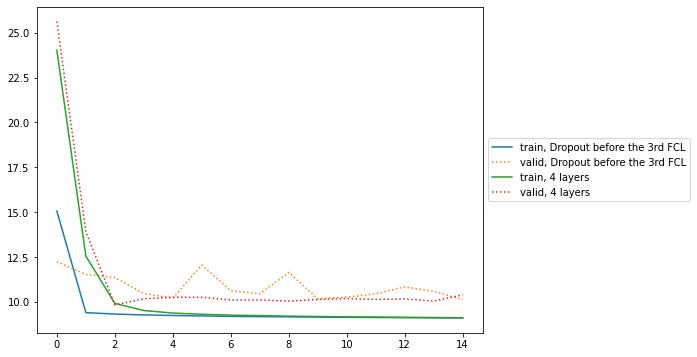

In [ ]:
# а что если добавить больше слоев 

bs = 650

train_loader_pca = DataLoader(train_set_pca, batch_size = bs, shuffle=True, worker_init_fn=set_random_seed,
      generator=g) 
test_loader_pca = DataLoader(test_set_pca, batch_size = bs, shuffle=True, worker_init_fn=set_random_seed,
      generator=g)

def get_model(n_input):
    set_random_seed(13) # используем функцию для фиксации рендом сида
    return torch.nn.Sequential(
    nn.Linear(n_input, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25, 1),
    nn.ReLU()     
)

model_4l = get_model(n_input)
optimizer = torch.optim.Adam(model_4l.parameters(), lr=0.0005)
four_layers = train_model(model_4l, optimizer, criterion, train_loader_pca, test_loader_pca, n_epochs)

fig = plt.figure()
fig.set_size_inches(8, 6)
ax = plt.subplot(111)

ax.plot(
      np.arange(n_epochs),
      do1[0],
      label="train, Dropout before the 3rd FCL"
  )
ax.plot(
      np.arange(n_epochs),
      do1[1],
      label="valid, Dropout before the 3rd FCL", linestyle = ':'
  )

ax.plot(
      np.arange(n_epochs),
      four_layers[0],
      label="train, 4 layers"
  )
ax.plot(
      np.arange(n_epochs),
      four_layers[1],
      label="valid, 4 layers", linestyle = ':'
  )

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Выгода не очевидна, но проверка на тесте показала, что качество у модели с 4 слоями выше, чем у модели с 3 слоями (как с 2, так и с 1 дропаутом).

### 6) Чтобы как-то еще побороть переобучение, попробуем уменьшить ширину первого слоя

In [ ]:
def get_model(n_input):
    set_random_seed(13) # используем функцию для фиксации рендом сида
    return torch.nn.Sequential(
    nn.Linear(n_input, 80),
    nn.BatchNorm1d(80),
    nn.ReLU(),
    nn.Linear(80, 45),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(45, 1),
    nn.ReLU()     
)

model_80 = get_model(n_input)
optimizer = torch.optim.Adam(model_80.parameters(), lr=0.0005)
m80 = train_model(model_80, optimizer, criterion, train_loader_pca, test_loader_pca, n_epochs)

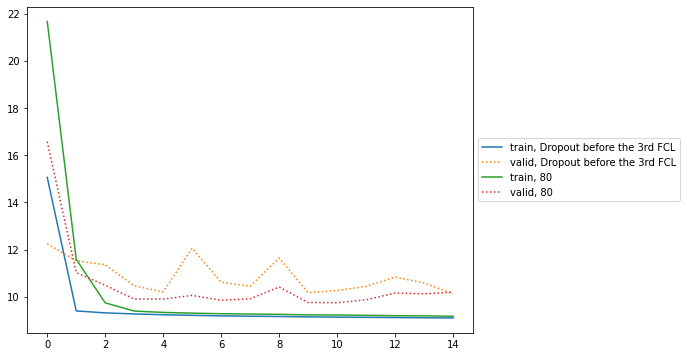

In [ ]:
fig = plt.figure()
fig.set_size_inches(8, 6)
ax = plt.subplot(111)

ax.plot(
      np.arange(n_epochs),
      do1[0],
      label="train, Dropout before the 3rd FCL"
  )
ax.plot(
      np.arange(n_epochs),
      do1[1],
      label="valid, Dropout before the 3rd FCL", linestyle = ':'
  )

ax.plot(
      np.arange(n_epochs),
      m80[0],
      label="train, 80"
  )
ax.plot(
      np.arange(n_epochs),
      m80[1],
      label="valid, 80", linestyle = ':'
  )

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Действительно, стало лучше. В дальнейшем будем пользоваться этой моделью. Уменьшение до 70 (не показано), привело с худшему результату, поэтому остановимся на 80.

### 7) Оптимайзер

По умолчанию я использовала Adam, поскольку на семинаре мы обсуждали, что он обычно работает лучше. Но очевидно, что это идивидуально для каждой отдельно взятой задачи, поэтому тут я попробовала применить еще и SGD с momentum = 0.9. КАк видно на графике, этот оптимайзер оказался значительно хуже на треине, но лучше на валидационной выборке (это же подтвердилось на полной тестовой выборке).

In [ ]:
# model with 4 layers with sgd

n_epochs = 15

def get_model(n_input):
    set_random_seed(13) # используем функцию для фиксации рендом сида
    return torch.nn.Sequential(
    nn.Linear(n_input, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25, 1),
    nn.ReLU()     
)

model_4l_sgd = get_model(n_input)
optimizer=torch.optim.SGD(model_4l_sgd.parameters(), momentum=0.9, lr=0.0005)
#optimizer = torch.optim.Adam(model_4l.parameters(), lr=0.0005)
four_layers_sgd = train_model(model_4l_sgd, optimizer, criterion, train_loader_pca, test_loader_pca, n_epochs)

Epoch 1 		 Training Loss: [12.97690219] 		 Validation Loss: 10.682297765518248
Validation Loss Decreased(inf--->2766.715121) 	 Saving The Model
Epoch 2 		 Training Loss: [10.659858] 		 Validation Loss: 10.376536089481075
Validation Loss Decreased(2766.715121--->2687.522847) 	 Saving The Model
Epoch 3 		 Training Loss: [10.48426302] 		 Validation Loss: 10.17907715580178
Validation Loss Decreased(2687.522847--->2636.380983) 	 Saving The Model
Epoch 4 		 Training Loss: [10.33446195] 		 Validation Loss: 10.091216181235884
Validation Loss Decreased(2636.380983--->2613.624991) 	 Saving The Model
Epoch 5 		 Training Loss: [10.22030889] 		 Validation Loss: 10.030529296536242
Validation Loss Decreased(2613.624991--->2597.907088) 	 Saving The Model
Epoch 6 		 Training Loss: [10.1287915] 		 Validation Loss: 10.006707480515292
Validation Loss Decreased(2597.907088--->2591.737237) 	 Saving The Model
Epoch 7 		 Training Loss: [10.05162148] 		 Validation Loss: 10.00514454823203
Validation Loss Decrea

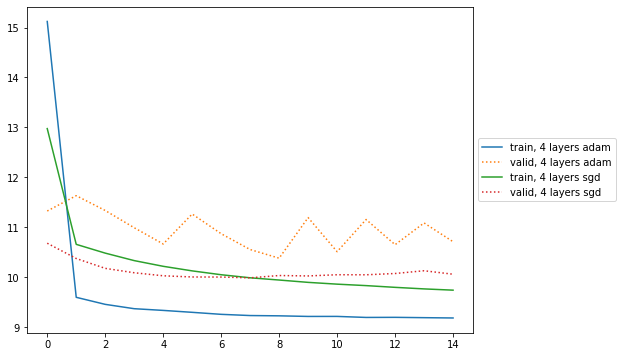

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(8, 6)
ax = plt.subplot(111)

ax.plot(
      np.arange(n_epochs),
      four_layers[0],
      label="train, 4 layers adam"
  )
ax.plot(
      np.arange(n_epochs),
      four_layers[1],
      label="valid, 4 layers adam", linestyle = ':'
  )

ax.plot(
      np.arange(n_epochs),
      four_layers_sgd[0],
      label="train, 4 layers sgd"
  )
ax.plot(
      np.arange(n_epochs),
      four_layers_sgd[1],
      label="valid, 4 layers sgd", linestyle = ':'
  )

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Cобственно, тест модели:

In [ ]:
def test(model, criterion, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    model.eval()
    loss_fn = criterion
    with torch.no_grad():
      test_features = test_loader.dataset[:,:][0]
      test_target = test_loader.dataset[:,:][1]
      predicts = model(test_features.float())
      loss = loss_fn(predicts.float(), test_target.float())

      print("loss:", loss, "\nloss (corrected):", loss / scale)

    return predicts

In [ ]:
assert result.shape[0] == y_test.shape[0]

In [85]:
scale

array([0.01123596])

In [86]:
n_input = pca.n_components_
bs = 128
n_epochs = 1000 # тренируем много эпох

In [ ]:
test(four_layers_sgd, criterion, test_loader_pca)

loss: tensor(0.0984) loss (corrected): tensor([8.7603], dtype=torch.float64)


tensor([[0.8833],
        [0.9209],
        [0.8956],
        ...,
        [0.8999],
        [0.9172],
        [0.9108]])

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Все немного смешалось, поэтому см. выше.